In [2]:
import gymnasium as gym 
import os
import numpy as np
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics 

import pickle

path = "/zhome/11/1/193832/resquivel/RL/Training_notebooks/data/sarsa/"

def save_object(obj,value,param):
    try:
        with open(f"{path}data_{value}.pickle", "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)
 

In [3]:
class sarsa:
    def __init__(self, environment_name, episodes, epsilon = 0.2, alpha=0.2, gamma=0.95, adj_param = ''):
        self.env = gym.make(environment_name)
        self.episodes = episodes
        self.episode_data = 500
        self.adj_param = adj_param
        self.ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': [], 'std': [], 'mid': []}
        
        # Initialize Q
        self.space_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        self.number_bins = 50
        self.Q = np.random.randn(self.number_bins, self.number_bins, self.number_bins, self.number_bins, self.action_size)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.ep_rewards_t = []

    def select_e_greedy(self, state, epsilon):
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state])

    def discretize_state(self, observation):
        pos_index = np.argmin(np.abs(np.linspace(self.lower_bounds[0], self.upper_bounds[0], num=self.number_bins).tolist() - observation[0]))
        vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[1], self.upper_bounds[1], num=self.number_bins).tolist() - observation[1]))
        ang_index = np.argmin(np.abs(np.linspace(self.lower_bounds[2], self.upper_bounds[2], num=self.number_bins).tolist() - observation[2]))
        ang_vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[3], self.upper_bounds[3], num=self.number_bins).tolist() - observation[3]))
        return pos_index, vel_index, ang_index, ang_vel_index

    def test_q(self):
        state, info = self.env.reset()
        score = 0 
        epsilon = 0.0
        d_state = self.discretize_state(state)
        action = self.select_e_greedy(d_state, epsilon)
        terminated = False
        truncated = False
        while not (terminated or truncated or score > 500):
            state_prime, reward, terminated, truncated, info = self.env.step(action)
            d_state_prime = self.discretize_state(state_prime)
            action_prime = self.select_e_greedy(d_state_prime, epsilon)
            d_state = d_state_prime
            action = action_prime
            score += reward
        self.env.close()
        return score

    def train(self):
        ep_rewards = []

        for episode in range(1, self.episodes + 1):
            state, info = self.env.reset()
            score = 0 
            d_state = self.discretize_state(state)
            action = self.select_e_greedy(d_state, self.epsilon)
            terminated = False
            truncated = False

            while not (terminated or truncated or score > 500):
                state_prime, reward, terminated, truncated, info = self.env.step(action)
                d_state_prime = self.discretize_state(state_prime)
                action_prime = self.select_e_greedy(d_state_prime, self.epsilon)
                self.Q[d_state + (action,)] += self.alpha * (reward + self.gamma * self.Q[d_state_prime + (action_prime,)] - self.Q[d_state + (action,)])
                d_state = d_state_prime
                action = action_prime
                score += reward

            t_score = self.test_q()
            ep_rewards.append(score)
            self.ep_rewards_t.append(t_score)

            if not episode % self.episode_data:
                avg_reward = sum(self.ep_rewards_t[-self.episode_data:]) / len(self.ep_rewards_t[-self.episode_data:])
                self.ep_rewards_table['ep'].append(episode)
                self.ep_rewards_table['avg'].append(avg_reward)
                self.ep_rewards_table['min'].append(min(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['max'].append(max(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['std'].append(np.std(self.ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['mid'].append(statistics.median(self.ep_rewards_t[-self.episode_data:]))
                
                print(f"Episode:{episode} avg:{avg_reward} min:{min(self.ep_rewards_t[-self.episode_data:])} max:{max(self.ep_rewards_t[-self.episode_data:])} std:{np.std(self.ep_rewards_t[-self.episode_data:])}")

        self.env.close()

# Usage






In [6]:
alphas = [0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
episodes = 2000
episode_data = 500
environment_name = "CartPole-v1"
agents_sarsa_a = []


agent = sarsa(environment_name, episodes, epsilon = 0.2, alpha= 0.4, gamma= 0.95)
agent.train()

Episode:500 avg:21.736 min:8.0 max:376.0 std:25.374205485098447


Episode:1000 avg:18.176 min:8.0 max:379.0 std:19.810023321541046
Episode:1500 avg:17.102 min:8.0 max:370.0 std:18.291189026413782
Episode:2000 avg:17.05 min:8.0 max:383.0 std:24.402366688499708


In [4]:
alphas = [0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
episodes = 50001
episode_data = 500
environment_name = "CartPole-v1"
agents_sarsa_a = []

for alpha in alphas:
    print(f"Alpha = {alpha}")
    agent = sarsa(environment_name, episodes, epsilon = 0.2, alpha= alpha, gamma= 0.95)
    agent.train()
    agents_sarsa_a.append(agent)

Alpha = 0.7
Episode:500 avg:21.622 min:8.0 max:117.0 std:12.683182408212852
Episode:1000 avg:18.192 min:8.0 max:76.0 std:10.379553747632892
Episode:1500 avg:17.37 min:8.0 max:84.0 std:10.337170792823343
Episode:2000 avg:16.152 min:8.0 max:61.0 std:7.842250697344482
Episode:2500 avg:17.168 min:8.0 max:72.0 std:8.966815265187524
Episode:3000 avg:17.442 min:8.0 max:118.0 std:10.941418372404923
Episode:3500 avg:16.492 min:8.0 max:91.0 std:9.137063861000424
Episode:4000 avg:17.764 min:8.0 max:112.0 std:9.61833166406732
Episode:4500 avg:20.768 min:8.0 max:500.0 std:25.96994755481805
Episode:5000 avg:20.714 min:8.0 max:500.0 std:25.13507915245146
Episode:5500 avg:26.272 min:8.0 max:500.0 std:39.074058094853676
Episode:6000 avg:31.33 min:8.0 max:500.0 std:56.864409783273054
Episode:6500 avg:32.792 min:8.0 max:500.0 std:43.93441402818523
Episode:7000 avg:32.994 min:8.0 max:500.0 std:49.47773200137613
Episode:7500 avg:42.104 min:8.0 max:500.0 std:63.3101033327225
Episode:8000 avg:54.898 min:8.0 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))


for agent in agents_sarsa_a:
    print(agent)
    df = pd.DataFrame(agent.ep_rewards_table)


    # Plot the mean rewards as a main line
    sns.lineplot(data=df, x='ep', y='avg_'+str(agent.param), label='Alpha '+str(agent.param))

    # Fill the area between (mean - std) and (mean + std) as the interval
    plt.fill_between(df['ep'], df['avg_'+str(agent.param)] - df['std_'+str(agent.param)], df['avg_'+str(agent.param)] + df['std_'+str(agent.param)], alpha=0.3)

# Customize the plot
plt.title('Mean Reward with Confidence Interval (Window Size = 500 Episodes)')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.legend()

# Show the plot
plt.show()

NameError: name 'agents_sarsa_a' is not defined

<Figure size 1000x600 with 0 Axes>

Alpha = 0.4

In [6]:
epsilons = [0.3, 0.2, 0.1, 0.05, 0.01]
episodes = 50001
episode_data = 500
environment_name = "CartPole-v1"
agents_sarsa_e = []

for epsilon in epsilons:
    print(f"epsilon = {epsilon}")
    agent = sarsa(environment_name, episodes, epsilon = epsilon, alpha= 0.4, gamma= 0.95)
    agent.train()
    agents_sarsa_e.append(agent)

epsilon = 0.3
Episode:500 avg:18.834 min:8.0 max:110.0 std:12.534210944451189
Episode:1000 avg:17.242 min:8.0 max:95.0 std:10.447556460723245
Episode:1500 avg:15.972 min:8.0 max:57.0 std:8.099087355992648
Episode:2000 avg:15.196 min:8.0 max:74.0 std:7.973304459256527
Episode:2500 avg:15.022 min:8.0 max:70.0 std:6.97434699452214
Episode:3000 avg:16.774 min:8.0 max:415.0 std:25.991901123234523
Episode:3500 avg:15.164 min:8.0 max:248.0 std:12.780809989981071
Episode:4000 avg:15.21 min:8.0 max:71.0 std:7.953483513530408
Episode:4500 avg:16.538 min:8.0 max:106.0 std:10.69020841705156
Episode:5000 avg:21.194 min:8.0 max:436.0 std:42.022807664410045
Episode:5500 avg:24.384 min:8.0 max:440.0 std:46.39466072728628
Episode:6000 avg:19.49 min:8.0 max:500.0 std:32.43383881072359
Episode:6500 avg:24.202 min:8.0 max:265.0 std:30.14732485644456
Episode:7000 avg:25.26 min:8.0 max:500.0 std:35.22221458114183
Episode:7500 avg:30.618 min:8.0 max:392.0 std:40.5781724083281
Episode:8000 avg:38.948 min:8.0 

/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

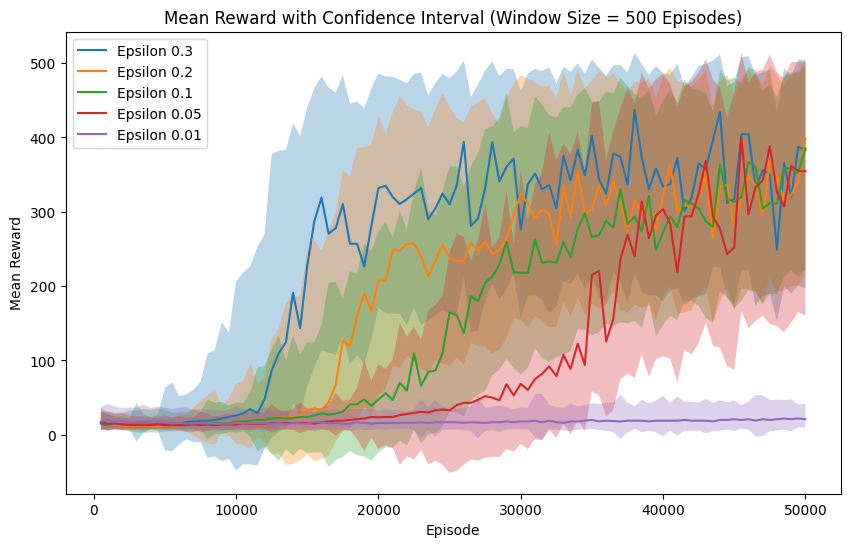

In [7]:
plt.figure(figsize=(10, 6))


for agent in agents_sarsa_e:
    #print(agent)
    if agent.param > 0.2:
        df = pd.DataFrame(agent.ep_rewards_table)


        # Plot the mean rewards as a main line
        sns.lineplot(data=df, x='ep', y='mid_'+str(agent.param), label='Epsilon '+str(agent.epsilon))

        # Fill the area between (mean - std) and (mean + std) as the interval
        plt.fill_between(df['ep'], df['avg_'+str(agent.param)] - df['std_'+str(agent.param)], df['avg_'+str(agent.param)] + df['std_'+str(agent.param)], alpha=0.3)

# Customize the plot
plt.title('Mean Reward with Confidence Interval (Window Size = 500 Episodes)')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.legend()

# Show the plot
plt.show()

In [8]:
gammas = [1, 0.95, 0.9, 0.85, 0.8]
episodes = 50001
episode_data = 500
environment_name = "CartPole-v1"
agents_sarsa_g = []

for gamma in gammas:
    print(f"gamma = {gamma}")
    agent = sarsa(environment_name, episodes, epsilon = 0.3, alpha= 0.4, gamma= gamma)
    agent.train()
    agents_sarsa_g.append(agent)

gamma = 1
Episode:500 avg:21.596 min:8.0 max:301.0 std:17.93300822505806
Episode:1000 avg:21.938 min:8.0 max:328.0 std:31.379390625058353
Episode:1500 avg:18.546 min:8.0 max:77.0 std:11.707941065789495
Episode:2000 avg:16.596 min:8.0 max:77.0 std:9.561421651616458
Episode:2500 avg:17.012 min:8.0 max:101.0 std:10.869215979085151
Episode:3000 avg:16.922 min:8.0 max:307.0 std:20.76833926918568
Episode:3500 avg:16.202 min:8.0 max:119.0 std:9.702432478507644
Episode:4000 avg:18.17 min:8.0 max:292.0 std:21.432337716637445
Episode:4500 avg:17.848 min:8.0 max:259.0 std:14.891907063905549
Episode:5000 avg:21.714 min:8.0 max:295.0 std:23.895526861737114
Episode:5500 avg:22.612 min:8.0 max:360.0 std:28.242476095413448
Episode:6000 avg:26.674 min:8.0 max:500.0 std:43.00041539334243
Episode:6500 avg:29.544 min:8.0 max:298.0 std:42.31340288844658
Episode:7000 avg:32.422 min:8.0 max:276.0 std:48.61040954363582
Episode:7500 avg:41.922 min:8.0 max:370.0 std:61.077392838921995
Episode:8000 avg:49.542 mi

/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/zhome/11/1/193832/.venv/dl/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

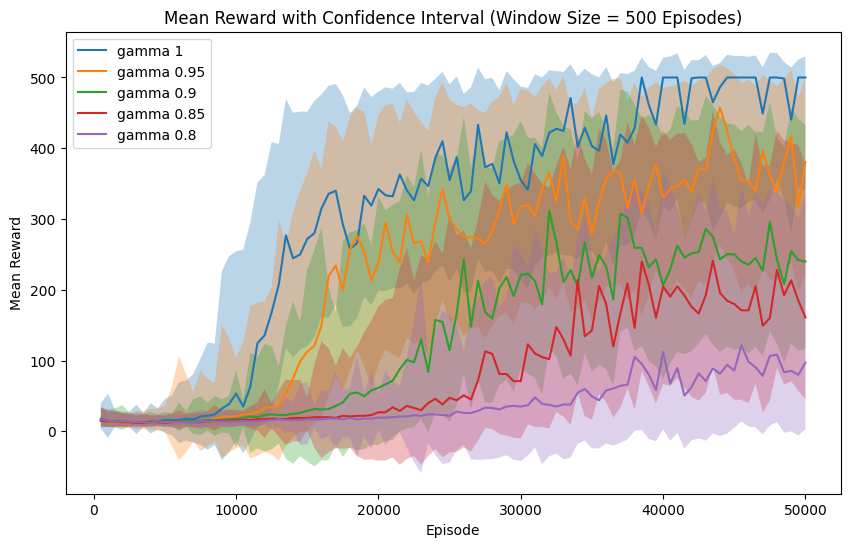

In [10]:
plt.figure(figsize=(10, 6))


for agent in agents_sarsa_g:
    #print(agent)
    if agent.param > 0:
        df = pd.DataFrame(agent.ep_rewards_table)


        # Plot the mean rewards as a main line
        sns.lineplot(data=df, x='ep', y='mid_'+str(agent.param), label='gamma '+str(agent.gamma))

        # Fill the area between (mean - std) and (mean + std) as the interval
        plt.fill_between(df['ep'], df['avg_'+str(agent.param)] - df['std_'+str(agent.param)], df['avg_'+str(agent.param)] + df['std_'+str(agent.param)], alpha=0.3)

# Customize the plot
plt.title('Mean Reward with Confidence Interval (Window Size = 500 Episodes)')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.legend()

# Show the plot
plt.show()

In [ ]:
episodes = 50001
episode_data = 500
environment_name = "CartPole-v1"
agents_sarsa_tt = []
n_agents = 50

for agent in range(n_agents):
    print(f"n_episode = {agent}")
    agent = sarsa(environment_name, episodes, epsilon = 0.3, alpha= 0.4, gamma=1)
    agent.train()
    agents_sarsa_g.append(agent)

## Q-learning


In [ ]:
class Qlearning:
    def __init__(self, environment_name, episodes, epsilon = 0.2, alpha=0.2, gamma=0.95):
        self.env = gym.make(environment_name)
        self.episodes = episodes
        self.episode_data = 500
        self.param = alpha
        self.ep_rewards_table = {'ep': [], 'avg_'+str(self.param): [], 'min_'+str(self.param): [], 'max_'+str(self.param): [], 'std_'+str(self.param): [], 'mid_'+str(self.param): []}
        
        # Initialize Q
        self.space_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        self.number_bins = 50
        self.Q = np.random.randn(self.number_bins, self.number_bins, self.number_bins, self.number_bins, self.action_size)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def select_e_greedy(self, state, epsilon):
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state])

    def discretize_state(self, observation):
        pos_index = np.argmin(np.abs(np.linspace(self.lower_bounds[0], self.upper_bounds[0], num=self.number_bins).tolist() - observation[0]))
        vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[1], self.upper_bounds[1], num=self.number_bins).tolist() - observation[1]))
        ang_index = np.argmin(np.abs(np.linspace(self.lower_bounds[2], self.upper_bounds[2], num=self.number_bins).tolist() - observation[2]))
        ang_vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[3], self.upper_bounds[3], num=self.number_bins).tolist() - observation[3]))
        return pos_index, vel_index, ang_index, ang_vel_index

    def test_q(self):
        state, info = self.env.reset()
        score = 0 
        epsilon = 0.0
        d_state = self.discretize_state(state)
        action = self.select_e_greedy(d_state, epsilon)
        terminated = False
        truncated = False
        while not (terminated or truncated or score > 500):
            state_prime, reward, terminated, truncated, info = self.env.step(action)
            d_state_prime = self.discretize_state(state_prime)
            action_prime = self.select_e_greedy(d_state_prime, epsilon)
            d_state = d_state_prime
            action = action_prime
            score += reward
        self.env.close()
        return score

    def train(self):
        ep_rewards = []
        ep_rewards_t = []

        for episode in range(1, self.episodes + 1):
            state, info = self.env.reset()
            score = 0 
            d_state = self.discretize_state(state)
            #action = self.select_e_greedy(d_state, self.epsilon)
            terminated = False
            truncated = False

            while not (terminated or truncated or score > 500):
                
                action = self.select_e_greedy(d_state, epsilon)

                state_prime, reward, terminated, truncated, info = self.env.step(action)
                d_state_prime = self.discretize_state(state_prime)        
            
                self.Q[d_state+(action,)] += self.alpha * (reward + self.gamma * np.max(self.Q[d_state_prime]) - self.Q[d_state+(action,)])
                
                d_state = d_state_prime
                score += reward

            t_score = self.test_q()
            ep_rewards.append(score)
            ep_rewards_t.append(t_score)

            if not episode % self.episode_data:
                avg_reward = sum(ep_rewards_t[-self.episode_data:]) / len(ep_rewards_t[-self.episode_data:])
                self.ep_rewards_table['ep'].append(episode)
                self.ep_rewards_table['avg_'+str(self.param)].append(avg_reward)
                self.ep_rewards_table['min_'+str(self.param)].append(min(ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['max_'+str(self.param)].append(max(ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['std_'+str(self.param)].append(np.std(ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['mid_'+str(self.param)].append(statistics.median(ep_rewards_t[-self.episode_data:]))
                
                print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards_t[-self.episode_data:])} max:{max(ep_rewards_t[-self.episode_data:])} std:{np.std(ep_rewards_t[-self.episode_data:])}")

        self.env.close()

In [ ]:
alphas = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
#alphas = [0.9, 0.8]
episodes = 50001
episode_data = 500
environment_name = "CartPole-v1"
agents_ql_alpha = []

for alpha in alphas:
    print(f"Alpha = {alpha}")
    agent = Qlearning(environment_name, episodes, epsilon = 0.25, alpha= alpha, gamma= 0.95)
    agent.train()
    agents_ql_alpha.append(agent)

In [ ]:
plt.figure(figsize=(10, 6))


for agent in agents_ql_alpha:
    #print(agent)
    if agent.param > 0.3:
        df = pd.DataFrame(agent.ep_rewards_table)


        # Plot the mean rewards as a main line
        sns.lineplot(data=df, x='ep', y='avg_'+str(agent.param), label='Alpha '+str(agent.param))

        # Fill the area between (mean - std) and (mean + std) as the interval
        #plt.fill_between(df['ep'], df['avg_'+str(agent.param)] - df['std_'+str(agent.param)], df['avg_'+str(agent.param)] + df['std_'+str(agent.param)], alpha=0.3)

# Customize the plot
plt.title('Mean Reward with Confidence Interval (Window Size = 500 Episodes)')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.legend()

# Show the plot
plt.show()

## MonteCarlo

In [ ]:
class MonteCarlo:
    def __init__(self, environment_name, episodes, epsilon = 0.2, alpha=0.2, gamma=0.95):
        self.env = gym.make(environment_name)
        self.episodes = episodes
        self.episode_data = 500
        self.param = alpha
        self.ep_rewards_table = {'ep': [], 'avg_'+str(self.param): [], 'min_'+str(self.param): [], 'max_'+str(self.param): [], 'std_'+str(self.param): [], 'mid_'+str(self.param): []}
        
        # Initialize Q
        self.space_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50) / 1.]
        self.lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50) / 1.]
        self.number_bins = 50
        self.Q = np.random.randn(self.number_bins, self.number_bins, self.number_bins, self.number_bins, self.action_size)
        self.C = np.zeros_like(self.Q)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def select_e_greedy(self, state, epsilon):
        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.Q[state])

    def discretize_state(self, observation):
        pos_index = np.argmin(np.abs(np.linspace(self.lower_bounds[0], self.upper_bounds[0], num=self.number_bins).tolist() - observation[0]))
        vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[1], self.upper_bounds[1], num=self.number_bins).tolist() - observation[1]))
        ang_index = np.argmin(np.abs(np.linspace(self.lower_bounds[2], self.upper_bounds[2], num=self.number_bins).tolist() - observation[2]))
        ang_vel_index = np.argmin(np.abs(np.linspace(self.lower_bounds[3], self.upper_bounds[3], num=self.number_bins).tolist() - observation[3]))
        return pos_index, vel_index, ang_index, ang_vel_index

    def test_q(self):
        state, info = self.env.reset()
        score = 0 
        epsilon = 0.0
        d_state = self.discretize_state(state)
        action = self.select_e_greedy(d_state, epsilon)
        terminated = False
        truncated = False
        while not (terminated or truncated or score > 500):
            state_prime, reward, terminated, truncated, info = self.env.step(action)
            d_state_prime = self.discretize_state(state_prime)
            action_prime = self.select_e_greedy(d_state_prime, epsilon)
            d_state = d_state_prime
            action = action_prime
            score += reward
        self.env.close()
        return score

    def train(self):
        ep_rewards = []
        ep_rewards_t = []

        for episode in range(1, self.episodes + 1):
            state, info = self.env.reset()
            score = 0 
            d_state = self.discretize_state(state)
            #action = self.select_e_greedy(d_state, self.epsilon)
            terminated = False
            truncated = False
            episode_states = []
            episode_actions = []
            episode_rewards = []
            
            
            while not (terminated or truncated or score > 500):
                action = self.select_e_greedy(d_state, epsilon)
                episode_states.append(d_state)
                episode_actions.append(action)
                
                state_prime, reward, terminated, truncated, _ = self.env.step(action)
                d_state_prime = self.discretize_state(state_prime)
                episode_rewards.append(reward)
                
                if terminated or truncated:
                    break
                
                d_state = d_state_prime

            ep_rewards.append(sum(episode_rewards))
            
            G = 0
            W = 1
            for t in range(len(episode_states)):
                t = len(episode_states)-t-1
                
                state_t = episode_states[t]
                action_t = episode_actions[t]
                G = episode_rewards[t] + self.gamma * sum(episode_rewards[t+1:])
                
                self.C[state_t + (action_t,)] += W
                self.Q[state_t + (action_t,)] += W/self.C[state_t + (action_t,)] * (G - self.Q[state_t + (action_t,)])
                W = W
            

            t_score = self.test_q()
            ep_rewards.append(score)
            ep_rewards_t.append(t_score)

            if not episode % self.episode_data:
                avg_reward = sum(ep_rewards_t[-self.episode_data:]) / len(ep_rewards_t[-self.episode_data:])
                self.ep_rewards_table['ep'].append(episode)
                self.ep_rewards_table['avg_'+str(self.param)].append(avg_reward)
                self.ep_rewards_table['min_'+str(self.param)].append(min(ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['max_'+str(self.param)].append(max(ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['std_'+str(self.param)].append(np.std(ep_rewards_t[-self.episode_data:]))
                self.ep_rewards_table['mid_'+str(self.param)].append(statistics.median(ep_rewards_t[-self.episode_data:]))
                
                print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards_t[-self.episode_data:])} max:{max(ep_rewards_t[-self.episode_data:])} std:{np.std(ep_rewards_t[-self.episode_data:])}")

        self.env.close()

In [ ]:
gammas = [1, 0.95, 0.9, 0.85, 0.8]
episodes = 50001
episode_data = 500
environment_name = "CartPole-v1"
agents_mc_g = []

for gamma in gammas:
    print(f"gamma = {gamma}")
    agent = MonteCarlo(environment_name, episodes, epsilon = 0.2, alpha= 0.4, gamma= gamma)
    agent.train()
    agents_mc_g.append(agent)